In [1]:
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torchvision.transforms.functional as TF
import tifffile
import yaml 
from einops import rearrange


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.registration.bigwarp import (
    read_bigwarp_warp_field, register_multiplex, register_visium, register_he, register_xenium, warp_pts)
from mushroom.data.multiplex import extract_ome_tiff, write_basic_ome_tiff, get_ome_tiff_channels, make_pseudo
from mushroom.data.visium import adata_from_visium, get_fullres_size
from mushroom.data.xenium import adata_from_xenium
from mushroom.data.he import read_he
from mushroom.visualization.utils import display_sections
import mushroom.utils as utils

In [7]:
run_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium'
bigwarp_dir = os.path.join(run_dir, 'registration')
registered_dir = os.path.join(run_dir, 'registered')
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [8]:
metadata = yaml.safe_load(open(os.path.join(bigwarp_dir, 'metadata.yaml')))
metadata

{'17B41236A': {'data': {'visium': {'17B41236A-A': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/kathleen/st/PC_A_spatial_outs/outs',
    '17B41236A-B': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/kathleen/st/PC_B_spatial_outs/outs',
    '17B41236A-C': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/kathleen/st/PC_C_spatial_outs/outs',
    '17B41236A-D': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/kathleen/st/PC_D_spatial_outs/outs'}},
  'ids': ['s0', 's1', 's2', 's3'],
  'order': ['17B41236A-A', '17B41236A-B', '17B41236A-C', '17B41236A-D'],
  'registered_pixels_per_micron': 1.1578182157391153,
  'scale': 0.2}}

In [9]:
fps = sorted(utils.listfiles(bigwarp_dir, regex=r'ddf.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registration/17B41236A/s1_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registration/17B41236A/s2_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registration/17B41236A/s3_ddf.tif']

In [10]:
keep = ['17B41236A']
metadata = {k:v for k, v in metadata.items() if k in keep}

In [11]:
case_to_ddfs = {}
for fp in fps:
    print(fp)
    case = fp.split('/')[-2]
    
    if case not in metadata:
        continue
    
    if case not in case_to_ddfs:
        case_to_ddfs[case] = {}
        
    scale = metadata[case]['scale']
    sid = re.findall(r'(s[0-9]+)_ddf.tif', fp)[0]
    ddf = read_bigwarp_warp_field(fp, scale)
    case_to_ddfs[case][sid] = ddf
    print(case, ddf.shape)
case_to_ddfs.keys() # c h w

/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registration/17B41236A/s1_ddf.tif
17B41236A torch.Size([2, 9405, 9670])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registration/17B41236A/s2_ddf.tif
17B41236A torch.Size([2, 9405, 9670])
/diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registration/17B41236A/s3_ddf.tif
17B41236A torch.Size([2, 9405, 9670])


dict_keys(['17B41236A'])

In [12]:
sid1, sid2 = metadata[keep[0]]['order'][:2]
adata1 = adata_from_visium(metadata[keep[0]]['data']['visium'][sid1])
adata2 = adata_from_visium(metadata[keep[0]]['data']['visium'][sid2])
adata1, adata2

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_u

(AnnData object with n_obs × n_vars = 4395 × 17943
     obs: 'in_tissue', 'array_row', 'array_col'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 4673 × 17943
     obs: 'in_tissue', 'array_row', 'array_col'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial')

In [13]:
ddf2 = case_to_ddfs[keep[0]]['s1']
ddf2.shape

torch.Size([2, 9405, 9670])

In [14]:
warped_adata2 = register_visium(
    adata2, ddf2
)
warped_adata2

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 4533 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_original'

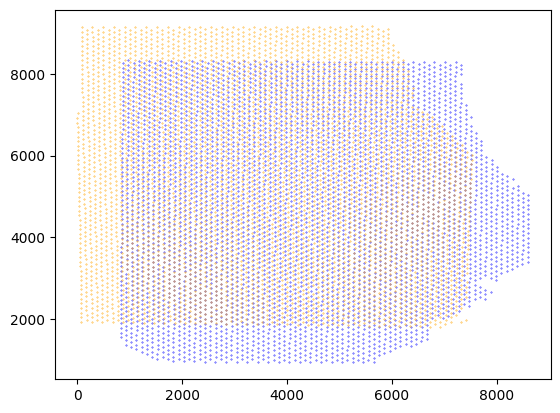

In [15]:
plt.scatter(adata1.obsm['spatial'][:, 0], adata1.obsm['spatial'][:, 1], s=.1, color='blue')
plt.scatter(warped_adata2.obsm['spatial'][:, 0], warped_adata2.obsm['spatial'][:, 1], s=.1, color='orange')

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


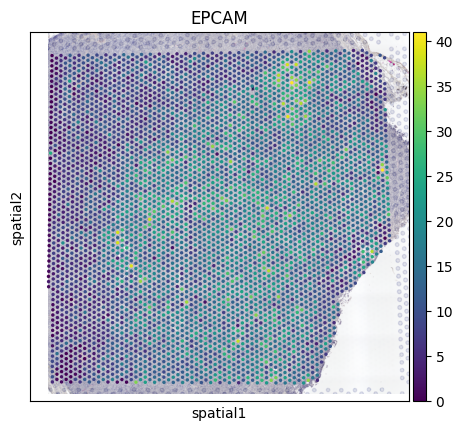

In [16]:
sc.pl.spatial(warped_adata2, color='EPCAM')

In [17]:
for case, data in metadata.items():
    ppm = data['registered_pixels_per_micron']
    ids = data['ids']
    order = data['order']
    directory = os.path.join(registered_dir, case)
    Path(directory).mkdir(parents=True, exist_ok=True)

    for dtype, mapping in data['data'].items():
        for sample, fp in mapping.items():
            print(dtype, sample, fp)
            sid = ids[order.index(sample)]
            ddf = case_to_ddfs[case].get(sid)

            if dtype == 'he':
                he = tifffile.imread(fp)
                he = rearrange(he, 'h w c -> c h w') # channel dim must be first
                if ddf is not None:
                    he = register_he(he, ddf)
                tifffile.imwrite(
                    os.path.join(directory, f'{sid}_{dtype}.tif'),
                    data=rearrange(he, 'c h w -> h w c'),
                    resolution=(ppm, ppm),
                    compression='LZW',
                    metadata={
                        'axes': 'YXC',
                        'unit': 'um',
                    }
                )
            elif dtype == 'visium':
                adata = adata_from_visium(fp)
                if ddf is not None:
                    adata = register_visium(
                        adata, ddf
                    )
                adata.write_h5ad(os.path.join(directory, f'{sid}_{dtype}.h5ad'))
            elif dtype == 'xenium':
                adata = adata_from_xenium(fp)
                print(get_fullres_size(adata))
                if ddf is not None:
                    adata = register_xenium(
                        adata, ddf
                    )
                print(get_fullres_size(adata))
                
                adata.write_h5ad(os.path.join(directory, f'{sid}_{dtype}.h5ad'))
            elif dtype == 'multiplex':
                channels, data = extract_ome_tiff(fp, as_dict=False)
                if ddf is not None:
                    data = register_multiplex(data, ddf)
                print(data.shape)
                write_basic_ome_tiff(
                    os.path.join(directory, f'{sid}_{dtype}.ome.tiff'),
                    data, channels, pix_per_micron=ppm
                )

visium 17B41236A-A /diskmnt/Projects/Users/estorrs/imaging-analysis/data/kathleen/st/PC_A_spatial_outs/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


visium 17B41236A-B /diskmnt/Projects/Users/estorrs/imaging-analysis/data/kathleen/st/PC_B_spatial_outs/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

visium 17B41236A-C /diskmnt/Projects/Users/estorrs/imaging-analysis/data/kathleen/st/PC_C_spatial_outs/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

visium 17B41236A-D /diskmnt/Projects/Users/estorrs/imaging-analysis/data/kathleen/st/PC_D_spatial_outs/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

In [18]:
registered_metadata = metadata.copy()
for case, data in registered_metadata.items():
    for dtype, mapping in data['data'].items():
        for sample, fp in mapping.items():
            sid = data['ids'][data['order'].index(sample)]
            if dtype in ['multiplex']:
                ext = 'ome.tiff'
            elif dtype in ['he']:
                ext = 'tif'
            elif dtype in ['visium', 'xenium']:
                ext = 'h5ad'
            else:
                raise RuntimeError(f'no valid extension found')
            fname = f'{sid}_{dtype}.{ext}'
            filepath = os.path.join(registered_dir, case, fname)
            mapping[sample] = filepath

In [21]:
# yaml.safe_dump(registered_metadata, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))

In [20]:
import sys
yaml.safe_dump(registered_metadata, sys.stdout)

17B41236A:
  data:
    visium:
      17B41236A-A: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registered/17B41236A/s0_visium.h5ad
      17B41236A-B: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registered/17B41236A/s1_visium.h5ad
      17B41236A-C: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registered/17B41236A/s2_visium.h5ad
      17B41236A-D: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/kathleen_visium/registered/17B41236A/s3_visium.h5ad
  ids:
  - s0
  - s1
  - s2
  - s3
  order:
  - 17B41236A-A
  - 17B41236A-B
  - 17B41236A-C
  - 17B41236A-D
  registered_pixels_per_micron: 1.1578182157391153
  scale: 0.2
